This notebook generates a model for review sentiment.
Let's mount Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


The following are commands to get the dataset. We do not need them, since we have already downloaded the dataset.

In [0]:
#!wget --no-check-certificate \
#    https://raw.githubusercontent.com/KeithGalli/sklearn/master/data/sentiment/Books_small_10000.json \
#    -O /tmp/reviews.json
#!wget --no-check-certificate \
#    http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Books_5.json.gz \
#    -O '/content/drive/My Drive/Colab Notebooks/reviews.json.gz'

Let's decompress the dataset from Google Drive to the /tmp folder.

In [0]:
!gunzip -c '/content/drive/My Drive/Colab Notebooks/reviews.json.gz' > /tmp/reviews.json

Let's import some libraries and check the Tensorflow version.

In [4]:
import json
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

2.2.0-rc4


Let's read the file and split the data into training and testing examples. We convert words to numbers by using the tokenizer. Finally we pad our sequences to make them of the same length.

In [5]:
reviews_num = 300000
embedding_dim = 100
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .9


with open("/tmp/reviews.json", 'r') as f:
  sentences = []
  labels = []
  neg = 0
  pos = 0
  for line in f:
    item = json.loads(line)
    valid = ('reviewText' in item) and ('overall' in item)
    if valid:
      sentence = item['reviewText']
      # Remove punctuation
      sentence = sentence.strip('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
      sentence = sentence.lower()
      sentences.append(sentence)
      is_positive = item['overall'] > 2.5
      if is_positive:
        pos += 1
      else:
        neg += 1
      labels.append(int(is_positive))
    if len(sentences) == reviews_num:
      break

print('Number of reviews: ', len(sentences))
print('Number of negative reviews: ', neg)
print('Number of positive reviews: ', pos)
tot = neg + pos

training_size = int(training_portion * len(sentences))
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)
print(vocab_size)

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

Number of reviews:  300000
Number of negative reviews:  23436
Number of positive reviews:  276564
154172


We will use the 100 dimension version of GLOVE as our first Embedding layer of our model.

In [6]:
# Note this is the 100 dimension version of GloVe from Stanford
# Laurence Moroney unzipped and hosted it on his site to make the notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-05-05 16:20:58--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 2404:6800:4008:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  84.4MB/s    in 3.9s    

2020-05-05 16:21:03 (84.4 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



Our dataset is imbalanced, since we have only a few negative reviews. We will take this into account by 'paying more attention' to negative reviews.

In [7]:
weight_for_0 = tot/neg/2.0 
weight_for_1 = tot/pos/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 6.40
Weight for class 1: 0.54


Let's compile the model and get its summary.

In [8]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 100)          15417300  
_________________________________________________________________
dropout (Dropout)            (None, 120, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                34048     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 15,453,461
Trainable params: 36,161
Non-trainable params: 15,417,300
_________________________________________________________________


Let's train our model.

In [9]:
num_epochs = 10
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
history = model.fit(
  training_padded,
  training_labels,
  epochs=num_epochs,
  validation_data=(testing_padded, testing_labels),
  class_weight = class_weight,
  verbose=1)


Epoch 1/10
8438/8438 [==============================] - 127s 15ms/step - loss: 0.4779 - accuracy: 0.7494 - val_loss: 0.3663 - val_accuracy: 0.8300
Epoch 2/10
8438/8438 [==============================] - 128s 15ms/step - loss: 0.4128 - accuracy: 0.7924 - val_loss: 0.3391 - val_accuracy: 0.8434
Epoch 3/10
8438/8438 [==============================] - 127s 15ms/step - loss: 0.3925 - accuracy: 0.8070 - val_loss: 0.4209 - val_accuracy: 0.7930
Epoch 4/10
8438/8438 [==============================] - 127s 15ms/step - loss: 0.3802 - accuracy: 0.8139 - val_loss: 0.3295 - val_accuracy: 0.8578
Epoch 5/10
8438/8438 [==============================] - 128s 15ms/step - loss: 0.3724 - accuracy: 0.8171 - val_loss: 0.3104 - val_accuracy: 0.8629
Epoch 6/10
8438/8438 [==============================] - 128s 15ms/step - loss: 0.3652 - accuracy: 0.8205 - val_loss: 0.3421 - val_accuracy: 0.8480
Epoch 7/10
8438/8438 [==============================] - 129s 15ms/step - loss: 0.3604 - accuracy: 0.8258 - val_loss: 0

Let's inspect some training metrics.

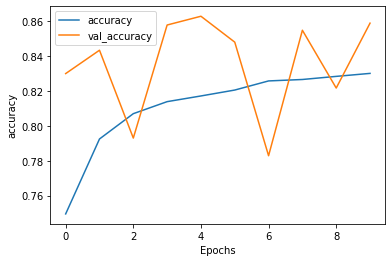

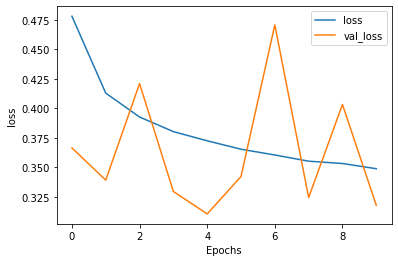

In [10]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

Now we can use our model to predict and see how it performs. Note that we need to preprocess our reviews the same way as we did with the training examples.

In [11]:
new_reviews = ["This book was very easy to read. I really enjoyed it.", "I would not recommend this book to anyone", "This book is not interesting","I am sure this book is chalk full of good info! However it is certainly not a beginners book to investing. If you're like me and have no idea what the definition of terms like 'net tangible assets', and 'sub working capital' are it may be best to find a true beginners book as a prequel to this one. Lots of good info I cant yet understand."]
new_reviews_stripped = []
for review in new_reviews:
  # Remove punctuation
  review = review.strip('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
  review = review.lower()
  new_reviews_stripped.append(review)
new_reviews_numeric = tokenizer.texts_to_sequences(new_reviews_stripped)
new_reviews_padded = pad_sequences(new_reviews_numeric, maxlen=max_length, padding=padding_type, truncating=trunc_type)
predictions = model.predict(new_reviews_padded);
print(predictions)

[[0.9865329 ]
 [0.06475276]
 [0.07624452]
 [0.11608034]]


Let's have the model's predictions on the testing samples and plot the ROC curve. We find the optimal output threshold, which maximizes the Youden's J statistic.

In [0]:
predictions = model.predict(testing_padded)

0.5272851


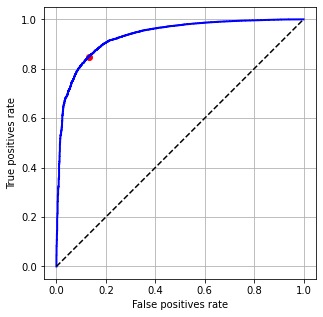

In [13]:
import sklearn.metrics

def plot_roc(name, labels, predictions, **kwargs):
  fpr, tpr, thresholds = sklearn.metrics.roc_curve(labels, predictions)
  plt.plot(fpr, tpr, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives rate')
  plt.ylabel('True positives rate')
  plt.grid(True)
  # Youden's J statistic
  J = tpr - fpr
  ix = np.argmax(J)
  best_threshold = thresholds[ix]
  plt.plot([0,1], [0,1], linestyle='--', color='k', label='No Skill')
  plt.scatter(fpr[ix], tpr[ix], marker='o', color='r', label='Best')
  ax = plt.gca()
  ax.set_aspect('equal')
  return best_threshold

plt.figure(figsize=(5,5))
best_threshold = plot_roc(
  "LSTM bidirectional",
  testing_labels,
  predictions,
  color='b')
print(best_threshold)

Let's save the word index of the tokenizer and the model.

In [0]:
with open( 'word_index.json' , 'w' ) as file:    
    json.dump( tokenizer.word_index , file )
model.save("amazon_reviews_sentiment.h5")

Let's install Tensorflow.js.

In [15]:
!pip install tensorflowjs

     |████████████████████████████████| 61kB 1.8MB/s 
     |████████████████████████████████| 92kB 4.4MB/s 
     |████████████████████████████████| 104.6MB 39kB/s 
     |████████████████████████████████| 3.9MB 36.6MB/s 
     |████████████████████████████████| 450kB 37.0MB/s 
     |████████████████████████████████| 256kB 36.5MB/s 
     |████████████████████████████████| 921kB 37.2MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32851 sha256=efb8329eb1a7e2561a64c29d46294865c348afc6722531e0fbbe22c27186f5a6
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=fa9d9486839b66bd8e6e0f67bcb675f8aa4bad9bdc63c1a8978494fcb0f6f975
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built PyInquirer gast
ERROR: tensorflow 2.2.0rc4 has requirement gast==0.3.3, bu

We use Tensorflow.js to convert our model to JSON format and zip it for download. This way our model can be loaded in a webpage using Javascript.

In [16]:
# import tensorflowjs as tfjs
# tfjs.converters.save_keras_model(model, 'model')
!tensorflowjs_converter --input_format=keras_saved_model amazon_reviews_sentiment.h5 model/
!zip -r /content/model.zip model/

2020-05-05 16:43:43.525664: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-05-05 16:43:43.530373: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2020-05-05 16:43:43.530685: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x18e6840 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-05-05 16:43:43.530722: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2020-05-05 16:43:44.902735: W tensorflow/c/c_api.cc:326] Operation '{name:'bidirectional/backward_lstm_1/while' id:497 op device:{} def:{{{node bidirectional/backward_lstm_1/while}} = While[T=[DT_INT32, DT_INT32, DT_INT32, DT_VARIANT, DT_FLOAT, ..., DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT], _l